In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/weiaicunzai/pytorch-cifar100

Cloning into 'pytorch-cifar100'...
remote: Enumerating objects: 1188, done.
remote: Total 1188 (delta 0), reused 0 (delta 0), pack-reused 1188
Receiving objects: 100% (1188/1188), 530.69 KiB | 2.67 MiB/s, done.
Resolving deltas: 100% (753/753), done.


In [ ]:
%cd pytorch-cifar100/

/content/pytorch-cifar100


In [ ]:
from models.resnet import resnet18

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms

import time
import numpy as np

In [ ]:
class Node(object):
    def __init__(self, dataset, shuffle, batch_size=128):
        self.dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    def set_more_hyperp(self, lr, mom, wd):
        self.LEARNING_RATE = lr
        self.MOMENTUM = mom
        self.WEIGHT_DECAY = wd

    def create_model(self):
        self.model = resnet18()
        self.model = nn.DataParallel(self.model).cuda()
    def load_model(self, other_node):
        self.model = resnet18()
        self.model.load_state_dict(other_node.model.module.state_dict())
        self.model = nn.DataParallel(self.model).cuda()
    def aggregate_then_load_model(self, other_nodes):
        params = [node.model.module.state_dict() for node in other_nodes]
        self.model = resnet18()
        param_master = dict(self.model.state_dict())
        for name in param_master:
            param_master[name] = 0
            for p in params:
                param_master[name] += p[name] * (1.0 / len(other_nodes))
        self.model.load_state_dict(param_master)
        self.model = nn.DataParallel(self.model).cuda()
    def save_model(self, path):
      torch.save(self.model.module.state_dict(), path)
    def load_saved_model(self, path):
      weights = torch.load(path)
      self.model = resnet18()
      self.model.load_state_dict(weights)
      self.model = nn.DataParallel(self.model).cuda()

    class AverageMeter(object):
        def __init__(self):
            self.reset()
        def reset(self):
            self.val = 0
            self.avg = 0
            self.sum = 0
            self.count = 0
        def update(self, val, n=1):
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count
    def accuracy(self, output, target, topk=(1,)):
        """Computes the precision@k for the specified values of k"""
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

    def train_model(self, which_epoch):
        criterion = nn.CrossEntropyLoss().cuda()
        optimizer = optim.SGD(self.model.parameters(), self.LEARNING_RATE, momentum=self.MOMENTUM, weight_decay=self.WEIGHT_DECAY)

        batch_time = self.AverageMeter()
        data_time = self.AverageMeter()
        losses = self.AverageMeter()
        top1 = self.AverageMeter()

        self.model.train()

        end = time.time()
        for i, (input, target) in enumerate(self.dataloader):
            # measure data loading time
            data_time.update(time.time() - end)

            input, target = input.cuda(), target.cuda()

            # compute output
            output = self.model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec = self.accuracy(output, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec.item(), input.size(0))

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
        
        return {
            'epoch': which_epoch,
            'batch_time.avg': batch_time.avg,
            'data_time.avg': data_time.avg,
            'losses.avg': losses.avg,
            'top1.avg': top1.avg}

    def evaluate_model(self):
        criterion = nn.CrossEntropyLoss().cuda()
        batch_time = self.AverageMeter()
        losses = self.AverageMeter()
        top1 = self.AverageMeter()

        # switch to evaluate mode
        self.model.eval()

        end = time.time()
        with torch.no_grad():
            for i, (input, target) in enumerate(self.dataloader):
                input, target = input.cuda(), target.cuda()

                # compute output
                output = self.model(input)
                loss = criterion(output, target)

                # measure accuracy and record loss
                prec = self.accuracy(output, target)[0]
                losses.update(loss.item(), input.size(0))
                top1.update(prec.item(), input.size(0))

                # measure elapsed time
                batch_time.update(time.time() - end)
                end = time.time()

        return {
            'batch_time.avg': batch_time.avg,
            'losses.avg': losses.avg,
            'top1.avg': top1.avg}

In [ ]:
CIFAR100_TRAIN_MEAN = [0.5070751592371323, 0.48654887331495095, 0.4409178433670343]
CIFAR100_TRAIN_STD = [0.2673342858792401, 0.2564384629170883, 0.27615047132568404]

train_dataset = torchvision.datasets.CIFAR100(
  root='./data',
  train=True,
  download=True,
  transform=transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_TRAIN_MEAN, CIFAR100_TRAIN_STD)
    ]))

test_dataset = torchvision.datasets.CIFAR100(
  root='./data',
  train=False,
  download=False,
  transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(CIFAR100_TRAIN_MEAN, CIFAR100_TRAIN_STD)
  ]))

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


CLASSIC TRAINING

In [ ]:
server_classic = Node(test_dataset, shuffle=False, batch_size=128)
client_classic = Node(train_dataset, shuffle=True, batch_size=128)
client_classic.create_model()
training_logs, testing_logs = [], []

In [ ]:
client_classic.set_more_hyperp(lr=0.1, mom=0.9, wd=5e-4)
for epoch in range(1, 20+1):
    training_logs.append(client_classic.train_model(epoch))
    server_classic.load_model(client_classic)
    testing_logs.append(server_classic.evaluate_model())
    print(training_logs[-1])
    print(testing_logs[-1])

{'epoch': 1, 'batch_time.avg': 0.34748696854047456, 'data_time.avg': 0.00357284570289085, 'losses.avg': 3.962310236816406, 'top1.avg': 9.09}
{'batch_time.avg': 0.10869331903095487, 'losses.avg': 3.614988480758667, 'top1.avg': 13.43}
{'epoch': 2, 'batch_time.avg': 0.34866335934690196, 'data_time.avg': 0.0034339330385408135, 'losses.avg': 3.3654900790405273, 'top1.avg': 17.798}
{'batch_time.avg': 0.10811860048318211, 'losses.avg': 3.336258583068848, 'top1.avg': 20.57}
{'epoch': 3, 'batch_time.avg': 0.3486738918382493, 'data_time.avg': 0.003492673034863094, 'losses.avg': 2.921759614715576, 'top1.avg': 26.09}
{'batch_time.avg': 0.10809768906122522, 'losses.avg': 2.7744102478027344, 'top1.avg': 29.33}
{'epoch': 4, 'batch_time.avg': 0.3486125176519994, 'data_time.avg': 0.003409546049659514, 'losses.avg': 2.526426815032959, 'top1.avg': 34.144}
{'batch_time.avg': 0.10822745214534711, 'losses.avg': 2.595032322692871, 'top1.avg': 33.26}
{'epoch': 5, 'batch_time.avg': 0.3485636833073843, 'data_ti

In [ ]:
client_classic.save_model('trained-model-epoch-20')

In [ ]:
client_classic.set_more_hyperp(lr=0.1, mom=0.9, wd=5e-4)
for epoch in range(21, 30+1):
    training_logs.append(client_classic.train_model(epoch))
    server_classic.load_model(client_classic)
    testing_logs.append(server_classic.evaluate_model())
    print(training_logs[-1])
    print(testing_logs[-1])

{'epoch': 21, 'batch_time.avg': 0.34732557989447316, 'data_time.avg': 0.0036392882656868155, 'losses.avg': 1.3557959514617919, 'top1.avg': 61.432}
{'batch_time.avg': 0.10803548595573328, 'losses.avg': 1.6294720294952392, 'top1.avg': 56.63}
{'epoch': 22, 'batch_time.avg': 0.34836134093496807, 'data_time.avg': 0.003665012471816119, 'losses.avg': 1.3512666953277588, 'top1.avg': 61.682}
{'batch_time.avg': 0.10809960546372813, 'losses.avg': 1.7013730962753295, 'top1.avg': 55.29}
{'epoch': 23, 'batch_time.avg': 0.3499395414386564, 'data_time.avg': 0.0036105518145939275, 'losses.avg': 1.3383345281219483, 'top1.avg': 61.772}
{'batch_time.avg': 0.10952035384842113, 'losses.avg': 1.5601480533599854, 'top1.avg': 57.57}
{'epoch': 24, 'batch_time.avg': 0.35101334823062047, 'data_time.avg': 0.0035216369287437185, 'losses.avg': 1.3258705700683593, 'top1.avg': 62.072}
{'batch_time.avg': 0.10926208616812018, 'losses.avg': 1.5714661674499513, 'top1.avg': 56.91}
{'epoch': 25, 'batch_time.avg': 0.35119297

In [ ]:
client_classic.save_model('trained-model-epoch-30')

In [ ]:
client_classic.set_more_hyperp(lr=0.02, mom=0.9, wd=5e-4)
for epoch in range(31, 40+1):
    training_logs.append(client_classic.train_model(epoch))
    server_classic.load_model(client_classic)
    testing_logs.append(server_classic.evaluate_model())
    print(training_logs[-1])
    print(testing_logs[-1])

{'epoch': 31, 'batch_time.avg': 0.3503056639600593, 'data_time.avg': 0.003823669365299937, 'losses.avg': 0.8110101011657714, 'top1.avg': 76.152}
{'batch_time.avg': 0.10901822923104974, 'losses.avg': 1.010975661277771, 'top1.avg': 70.69}
{'epoch': 32, 'batch_time.avg': 0.3495160667487727, 'data_time.avg': 0.0038308889969535494, 'losses.avg': 0.6677106137657165, 'top1.avg': 79.986}
{'batch_time.avg': 0.10937377470958082, 'losses.avg': 1.0129452381134034, 'top1.avg': 71.26}
{'epoch': 33, 'batch_time.avg': 0.3498897924447608, 'data_time.avg': 0.003686883565410019, 'losses.avg': 0.6028931803321839, 'top1.avg': 82.122}
{'batch_time.avg': 0.11003841025919854, 'losses.avg': 1.0202454795837403, 'top1.avg': 71.32}
{'epoch': 34, 'batch_time.avg': 0.3510475353816586, 'data_time.avg': 0.004162974979566491, 'losses.avg': 0.5527554134559631, 'top1.avg': 83.216}
{'batch_time.avg': 0.10940356797809843, 'losses.avg': 1.0846254504203796, 'top1.avg': 69.9}
{'epoch': 35, 'batch_time.avg': 0.349957684421783

In [ ]:
client_classic.save_model('trained-model-epoch-40')

In [ ]:
import json
with open('classic_logs.json', 'w') as outfile:
    outfile.write(str(json.dumps({'training_logs': training_logs, 'testing_logs': testing_logs})))

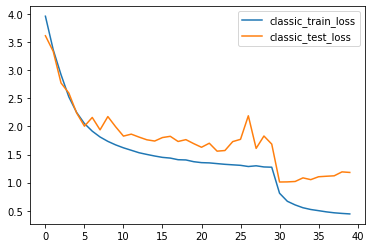

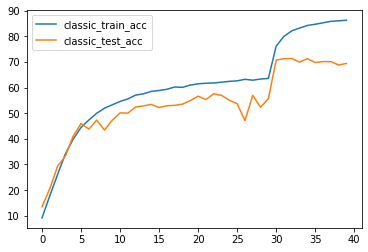

In [ ]:
import matplotlib.pyplot as plt

plt.plot([x['losses.avg'] for x in training_logs], label='classic_train_loss')
plt.plot([x['losses.avg'] for x in testing_logs], label='classic_test_loss')
plt.legend()
plt.show()

plt.plot([x['top1.avg'] for x in training_logs], label='classic_train_acc')
plt.plot([x['top1.avg'] for x in testing_logs], label='classic_test_acc')
plt.legend()
plt.show()

DISTRIBUTED SYNCHRONOUS TRAINING - 5 Clients

In [ ]:
train_split_datasest = random_split(train_dataset, [10000, 10000, 10000, 10000, 10000])
clients_subsets = [Node(data, shuffle=True) for data in train_split_datasest]
server_federator = Node(test_dataset, shuffle=False)
server_federator.create_model()

training_logs, testing_logs = [], []

In [ ]:
for client in clients_subsets:
    client.set_more_hyperp(lr=0.1, mom=0.9, wd=5e-4)

for epoch in range(1, 20+1):
    all_client_logs = {}
    for client_idx in range(len(clients_subsets)):
        client = clients_subsets[client_idx]
        client.load_model(server_federator)
        all_client_logs[str(client_idx)] = client.train_model(epoch)
    training_logs.append(all_client_logs)
    server_federator.aggregate_then_load_model(clients_subsets)
    testing_logs.append(server_federator.evaluate_model())
    print(training_logs[-1])
    print(testing_logs[-1])

{'0': {'epoch': 1, 'batch_time.avg': 0.35175741775126396, 'data_time.avg': 0.006270828126352044, 'losses.avg': 4.494729347991943, 'top1.avg': 4.11}, '1': {'epoch': 1, 'batch_time.avg': 0.3520713093914563, 'data_time.avg': 0.005992086627815343, 'losses.avg': 4.668322801971436, 'top1.avg': 3.21}, '2': {'epoch': 1, 'batch_time.avg': 0.3564066404028784, 'data_time.avg': 0.005333782751348954, 'losses.avg': 4.471716317367553, 'top1.avg': 3.9}, '3': {'epoch': 1, 'batch_time.avg': 0.35565025595170036, 'data_time.avg': 0.0051940573921686484, 'losses.avg': 4.456500876617431, 'top1.avg': 3.82}, '4': {'epoch': 1, 'batch_time.avg': 0.3556616004509262, 'data_time.avg': 0.005821315548087977, 'losses.avg': 4.5506383880615235, 'top1.avg': 3.55}}
{'batch_time.avg': 0.11048891876317278, 'losses.avg': 4.712153092193604, 'top1.avg': 1.0}
{'0': {'epoch': 2, 'batch_time.avg': 0.3550529419621335, 'data_time.avg': 0.005151932752585109, 'losses.avg': 4.123700642395019, 'top1.avg': 6.16}, '1': {'epoch': 2, 'batc

In [ ]:
server_federator.save_model('/content/drive/MyDrive/ColabData/server_federator_model-epoch-20')

In [ ]:
for client in clients_subsets:
    client.set_more_hyperp(lr=0.1, mom=0.9, wd=5e-4)

for epoch in range(21, 30+1):
    all_client_logs = {}
    for client_idx in range(len(clients_subsets)):
        client = clients_subsets[client_idx]
        client.load_model(server_federator)
        all_client_logs[str(client_idx)] = client.train_model(epoch)
    training_logs.append(all_client_logs)
    server_federator.aggregate_then_load_model(clients_subsets)
    testing_logs.append(server_federator.evaluate_model())
    print(training_logs[-1])
    print(testing_logs[-1])

{'0': {'epoch': 21, 'batch_time.avg': 0.35635950897313373, 'data_time.avg': 0.005019184909289396, 'losses.avg': 2.230468118286133, 'top1.avg': 40.16}, '1': {'epoch': 21, 'batch_time.avg': 0.3550312066379982, 'data_time.avg': 0.005028133150897449, 'losses.avg': 2.253281065368652, 'top1.avg': 39.6}, '2': {'epoch': 21, 'batch_time.avg': 0.3552688405483584, 'data_time.avg': 0.0051552374151688585, 'losses.avg': 2.2818061130523684, 'top1.avg': 39.4}, '3': {'epoch': 21, 'batch_time.avg': 0.3547463205796254, 'data_time.avg': 0.005066865607153011, 'losses.avg': 2.3008174533843992, 'top1.avg': 38.78}, '4': {'epoch': 21, 'batch_time.avg': 0.35483969314188896, 'data_time.avg': 0.004868775983399983, 'losses.avg': 2.2688147918701174, 'top1.avg': 39.92}}
{'batch_time.avg': 0.11030969136877905, 'losses.avg': 2.0082332405090333, 'top1.avg': 45.75}
{'0': {'epoch': 22, 'batch_time.avg': 0.3555302499215814, 'data_time.avg': 0.0051757866823220556, 'losses.avg': 2.1676310684204103, 'top1.avg': 42.21}, '1': 

In [ ]:
server_federator.save_model('/content/drive/MyDrive/ColabData/server_federator_model-epoch-30')

In [17]:
server_federator.load_saved_model('/content/drive/MyDrive/ColabData/server_federator_model-epoch-30')

for client in clients_subsets:
    client.set_more_hyperp(lr=0.1, mom=0.9, wd=5e-4)

for epoch in range(31, 40+1):
    all_client_logs = {}
    for client_idx in range(len(clients_subsets)):
        client = clients_subsets[client_idx]
        client.load_model(server_federator)
        all_client_logs[str(client_idx)] = client.train_model(epoch)
    training_logs.append(all_client_logs)
    server_federator.aggregate_then_load_model(clients_subsets)
    testing_logs.append(server_federator.evaluate_model())
    print(training_logs[-1])
    print(testing_logs[-1])

{'0': {'epoch': 31, 'batch_time.avg': 0.35662402684175515, 'data_time.avg': 0.0053041826320599905, 'losses.avg': 1.7276952533721923, 'top1.avg': 50.9}, '1': {'epoch': 31, 'batch_time.avg': 0.355999949612195, 'data_time.avg': 0.005191875409476365, 'losses.avg': 1.7405339466094971, 'top1.avg': 51.3}, '2': {'epoch': 31, 'batch_time.avg': 0.35502199583415744, 'data_time.avg': 0.005215949650052227, 'losses.avg': 1.757961434173584, 'top1.avg': 51.16}, '3': {'epoch': 31, 'batch_time.avg': 0.3547745384747469, 'data_time.avg': 0.0052428215364866615, 'losses.avg': 1.7910679954528808, 'top1.avg': 50.14}, '4': {'epoch': 31, 'batch_time.avg': 0.35478381265567827, 'data_time.avg': 0.005317703078064738, 'losses.avg': 1.7581936336517334, 'top1.avg': 51.46}}
{'batch_time.avg': 0.11088102678709393, 'losses.avg': 1.5985440700531006, 'top1.avg': 55.34}
{'0': {'epoch': 32, 'batch_time.avg': 0.35514780841296234, 'data_time.avg': 0.005568670321114456, 'losses.avg': 1.7015948984146119, 'top1.avg': 52.63}, '1'

In [18]:
server_federator.save_model('/content/drive/MyDrive/ColabData/server_federator_model-epoch-40')

In [19]:
server_federator.load_saved_model('/content/drive/MyDrive/ColabData/server_federator_model-epoch-40')

for client in clients_subsets:
    client.set_more_hyperp(lr=0.1, mom=0.9, wd=5e-4)

for epoch in range(41, 50+1):
    all_client_logs = {}
    for client_idx in range(len(clients_subsets)):
        client = clients_subsets[client_idx]
        client.load_model(server_federator)
        all_client_logs[str(client_idx)] = client.train_model(epoch)
    training_logs.append(all_client_logs)
    server_federator.aggregate_then_load_model(clients_subsets)
    testing_logs.append(server_federator.evaluate_model())
    print(training_logs[-1])
    print(testing_logs[-1])

{'0': {'epoch': 41, 'batch_time.avg': 0.35617229304736175, 'data_time.avg': 0.005097935471353652, 'losses.avg': 1.4539156700134277, 'top1.avg': 58.59}, '1': {'epoch': 41, 'batch_time.avg': 0.3559974266003959, 'data_time.avg': 0.004804170584376854, 'losses.avg': 1.473900043296814, 'top1.avg': 58.24}, '2': {'epoch': 41, 'batch_time.avg': 0.35480992703498165, 'data_time.avg': 0.004855113693430454, 'losses.avg': 1.522556209564209, 'top1.avg': 56.86}, '3': {'epoch': 41, 'batch_time.avg': 0.3546006830432747, 'data_time.avg': 0.005016338976123665, 'losses.avg': 1.5266427192687988, 'top1.avg': 56.64}, '4': {'epoch': 41, 'batch_time.avg': 0.35451820832264574, 'data_time.avg': 0.005089684377742719, 'losses.avg': 1.4895632246017456, 'top1.avg': 58.35}}
{'batch_time.avg': 0.11064072500301313, 'losses.avg': 1.3697725704193116, 'top1.avg': 61.12}
{'0': {'epoch': 42, 'batch_time.avg': 0.35471798498419266, 'data_time.avg': 0.0047298051133940495, 'losses.avg': 1.4205538583755493, 'top1.avg': 59.06}, '1

In [20]:
server_federator.save_model('/content/drive/MyDrive/ColabData/server_federator_model-epoch-50')

In [21]:
server_federator.load_saved_model('/content/drive/MyDrive/ColabData/server_federator_model-epoch-50')

for client in clients_subsets:
    client.set_more_hyperp(lr=0.02, mom=0.9, wd=5e-4)

for epoch in range(51, 60+1):
    all_client_logs = {}
    for client_idx in range(len(clients_subsets)):
        client = clients_subsets[client_idx]
        client.load_model(server_federator)
        all_client_logs[str(client_idx)] = client.train_model(epoch)
    training_logs.append(all_client_logs)
    server_federator.aggregate_then_load_model(clients_subsets)
    testing_logs.append(server_federator.evaluate_model())
    print(training_logs[-1])
    print(testing_logs[-1])

{'0': {'epoch': 51, 'batch_time.avg': 0.3560702076441125, 'data_time.avg': 0.004950052575220036, 'losses.avg': 0.8532016199111938, 'top1.avg': 74.78}, '1': {'epoch': 51, 'batch_time.avg': 0.3546935003015059, 'data_time.avg': 0.004909080795094937, 'losses.avg': 0.8770643642425537, 'top1.avg': 74.6}, '2': {'epoch': 51, 'batch_time.avg': 0.3545760625525366, 'data_time.avg': 0.004995877229714695, 'losses.avg': 0.8949547733306885, 'top1.avg': 73.9}, '3': {'epoch': 51, 'batch_time.avg': 0.354367144500153, 'data_time.avg': 0.0054590702056884766, 'losses.avg': 0.9091730938911438, 'top1.avg': 72.95}, '4': {'epoch': 51, 'batch_time.avg': 0.3541613198533843, 'data_time.avg': 0.005364348616781114, 'losses.avg': 0.88061630153656, 'top1.avg': 74.87}}
{'batch_time.avg': 0.11027060882954658, 'losses.avg': 1.08081711769104, 'top1.avg': 68.9}
{'0': {'epoch': 52, 'batch_time.avg': 0.3540266193921053, 'data_time.avg': 0.005130001261264463, 'losses.avg': 0.7835181324005127, 'top1.avg': 77.02}, '1': {'epoch

In [45]:
import json
with open('/content/drive/MyDrive/ColabData/fed_5clientIID-1ClientEpoch_logs.json', 'w') as outfile:
    outfile.write(str(json.dumps({'training_logs': training_logs, 'testing_logs': testing_logs})))

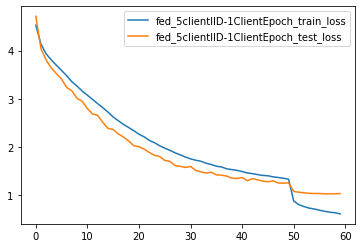

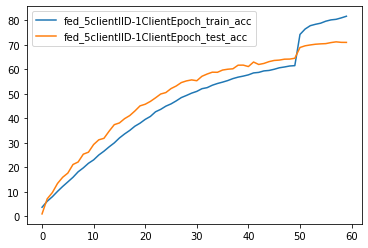

In [46]:
import matplotlib.pyplot as plt

plt.plot([np.mean([x[str(i)]['losses.avg'] for i in range(5)]) for x in training_logs], label='fed_5clientIID-1ClientEpoch_train_loss')
plt.plot([x['losses.avg'] for x in testing_logs], label='fed_5clientIID-1ClientEpoch_test_loss')
plt.legend()
plt.show()
plt.plot([np.mean([x[str(i)]['top1.avg'] for i in range(5)]) for x in training_logs], label='fed_5clientIID-1ClientEpoch_train_acc')
plt.plot([x['top1.avg'] for x in testing_logs], label='fed_5clientIID-1ClientEpoch_test_acc')
plt.legend()
plt.show()